# Active Travel Accessibility and Percolation in Greater London
## 1 Establish environment and dataset for analysis

In [1]:
# Import necessary libraries
from datetime import datetime, timedelta

# pandas and matplotlib for data processing and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# geopandas and h3 libraries for spatial data processing
import geopandas as gpd
import h3
import h3pandas
from shapely.geometry import LineString
import contextily as cx

# R5Py for travel time matrix computation
from r5py import TransportNetwork, TravelTimeMatrixComputer

# NetworkX for percolation analysis
import networkx as nx

In [2]:
gla_boundary = gpd.read_file('spatial/gla_boundary.geojson',crs='EPSG:4326')
borough_boundary = gpd.read_file('spatial/London_Borough_Excluding_MHW.shp').to_crs('EPSG:4326')
# gla_boundary.plot()

# Setting level for H3 grid
h3_level = 8

# Might want to change h3 level to 9, if the computation power is enough
# h3_level = 9


# Generate hexagons within the boundary use h3pandas
gla_hexagons = gla_boundary.h3.polyfill_resample(h3_level)

# Drop the generated index column and reset the index
gla_hexagons.drop(columns=['index'], inplace=True)
gla_hexagons = gla_hexagons.reset_index(drop=False)
# gla_hexagons.plot()

In [3]:
print('Number of hexagons:', len(gla_hexagons))
gla_hexagons.head()
# gla_hexagons.to_file('gla_hexagons.geojson', driver='GeoJSON')

Number of hexagons: 16890


,h3_polyfill,geometry
0,89194ada6cbffff,"POLYGON ((-0.24886 51.51446, -0.25095 51.51348..."
1,89194e6d34bffff,"POLYGON ((0.06367 51.46788, 0.06158 51.46691, ..."
2,89194ad9223ffff,"POLYGON ((-0.38817 51.45470, -0.39026 51.45372..."
3,89194e61cbbffff,"POLYGON ((0.22420 51.58344, 0.22210 51.58247, ..."
4,89194e6c397ffff,"POLYGON ((0.17799 51.45707, 0.17590 51.45610, ..."


## 2 Calculate active travel accessibility using R5Py

In [4]:
# Create a TransportNetwork object in R5Py
from r5py import TransportNetwork, TravelTimeMatrixComputer

transport_network = TransportNetwork(
    'r5/greater-london-latest.osm.pbf',
    
    ######### or we can directly fectch from OSM #######
    # from pyrosm import get_data, OSM

    # fp = get_data("London")
    # osm = OSM(fp)
    
    #'r5/improved-gtfs-london-dft.zip'  # Here we use a GTFS feed to calculate public transport travel times, but it will not be used in this example
)

In [5]:
# Calculate centroids only once and use it for both origins and destinations
centroids = gla_hexagons.centroid

# Create a single GeoDataFrame and set the CRS in the same step
origins_destinations = gpd.GeoDataFrame({'id': gla_hexagons['h3_polyfill'], 'geometry': centroids}, crs=gla_hexagons.crs)

# Since both origins and destinations are identical, clone the dataframe
origins = origins_destinations.copy()
destinations = origins_destinations.copy()

/var/folders/1m/ypxywhtn55lb617x58888rqh0000gn/T/ipykernel_98613/505000223.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gla_hexagons.centroid


In [6]:
# Create a TravelTimeMatrixComputer object using R5Py to calculate travel times
travel_time_computer = TravelTimeMatrixComputer(transport_network,
                                                origins=origins, destinations=destinations, 
                                                #snap_to_network=True,
                                                transport_modes=['WALK','BICYCLE'],
                                                max_time=timedelta(minutes=60)
                                                )

In [8]:
# Compute travel times between all origins and destinations
od_matrix = travel_time_computer.compute_travel_times()
# print(time_matrix.head())

In [9]:
# Build an OD matrix with generated time matrix

od_matrix = pd.merge(od_matrix, origins_destinations, how='left', left_on='from_id', right_on='id', suffixes=('', '_from'))
od_matrix = pd.merge(od_matrix, origins_destinations, how='left', left_on='to_id', right_on='id', suffixes=('_from', '_to'))

# od_matrix.head()

In [10]:
# Filter rows where travel_time is not NaN
valid_od_matrix = od_matrix[~od_matrix['travel_time'].isna()].copy()

# Create LineStrings from the valid rows
valid_od_matrix['geometry'] = valid_od_matrix.apply(lambda row: LineString([row['geometry_from'], row['geometry_to']]), axis=1)

# Convert to GeoDataFrame
time_matrix = gpd.GeoDataFrame(valid_od_matrix, geometry='geometry')

In [18]:
# Save the time matrix to a CSV file for future reference
# time_matrix.to_csv('time_matrix.csv')

KeyboardInterrupt: 

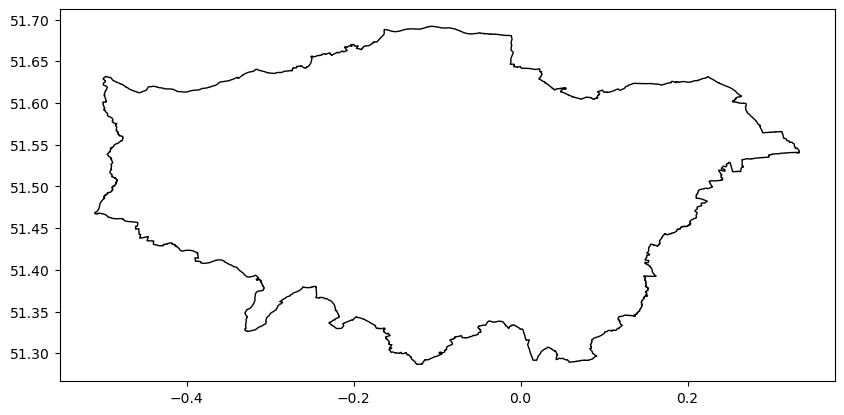

In [11]:
# Build a plot to show the travel times pairs
fig, ax = plt.subplots(figsize=(10,8))  # Adjust size as needed

# Plot the GLA boundary for context
gla_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

# Plot the OD lines on the same axes
time_matrix.plot(ax=ax, column = "travel_time", scheme='natural_breaks', alpha=0.0005)

# Optional: Add labels, title, or grid
ax.set_title('OD pairs of accessibility in Greater London')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

## 3 Visualize active travel accessibility

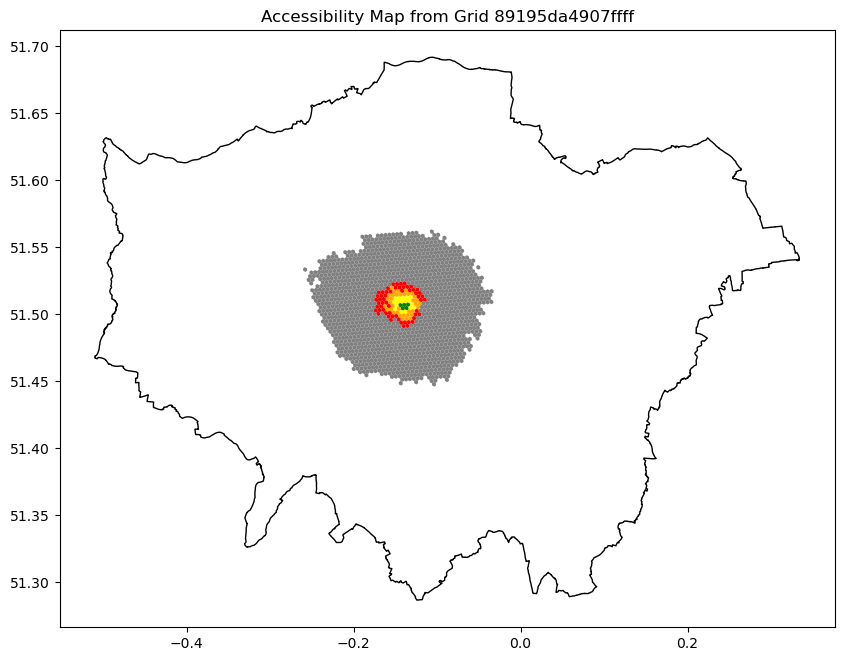

In [12]:
# Plot the travel time matrix for a specific origin

# Select a specific 'from_id' to analyze (replace 'your_selected_id' with the actual grid ID)
selected_id = '89195da4907ffff'
filtered_time_matrix = time_matrix[time_matrix['from_id'] == selected_id].drop(columns=['geometry'])

# Merge filtered time matrix with centroids to get spatial data
access_map = pd.merge(filtered_time_matrix, gla_hexagons, how='left', left_on='to_id', right_on='h3_polyfill')

# Convert to a GeoDataFrame
access_map = gpd.GeoDataFrame(access_map, geometry='geometry', crs=origins_destinations.crs)

# Categorize travel times into intervals
time_bins = [0, 5, 10, 15, 20, float('inf')]  # time intervals
time_labels = ['0-5 min', '5-10 min', '10-15 min', '15-20 min', '>20 min']
access_map['time_category'] = pd.cut(access_map['travel_time'], bins=time_bins, labels=time_labels, include_lowest=True)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10,8))
for category, color in zip(time_labels, ['green', 'yellow', 'orange', 'red', 'grey']):
    data = access_map[access_map['time_category'] == category]
    data.plot(ax=ax, color=color, label=category,markersize=0.5)

# Add GLA boundary for context
gla_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

# ax.legend(title='Travel Time')
ax.set_title('Accessibility Map from Grid ' + selected_id)
plt.show()

In [ ]:
# Plot the travel time matrix for multiple specific origin

# List of selected grid IDs to analyze
selected_ids = ['88194ad365fffff', '88195da495fffff','88195daeb9fffff']  # Replace these with your grid IDs

# Define time bins and labels for categorization
time_bins = [0, 5, 10, 15, 20, float('inf')]  # time intervals
time_labels = ['0-5 min', '5-10 min', '10-15 min', '15-20 min', '>20 min']
colors = ['green', 'yellow', 'orange', 'red', 'grey']

# Prepare the plot
fig, ax = plt.subplots(figsize=(10,8))

# Add GLA boundary for context
gla_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

# Process each grid ID and plot on the same map
for grid_id in selected_ids:
    # Filter time matrix for the current grid ID
    filtered_time_matrix = time_matrix[time_matrix['from_id'] == grid_id].drop(columns=['geometry'])

    # Merge with centroids to get spatial data
    access_map = pd.merge(filtered_time_matrix, gla_hexagons, how='left', left_on='to_id', right_on='h3_polyfill')
    access_map = gpd.GeoDataFrame(access_map, geometry='geometry', crs=origins_destinations.crs)
    access_map['time_category'] = pd.cut(access_map['travel_time'], bins=time_bins, labels=time_labels, include_lowest=True)

    # Plot each category
    for category, color in zip(time_labels, colors):
        data = access_map[access_map['time_category'] == category]
        data.plot(ax=ax,color=color, label=f"{grid_id} - {category}",markersize=0.5)

# Formatting and legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicate labels

#ax.legend(by_label.values(), by_label.keys(), title='Travel Time')
ax.set_title('Accessibility Map for Selected Grids')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect('equal')

plt.show()

## Currently, the accessibility plots are overlaid on top of each other, which will be solved in later attempts

## 4 Percolation analysis on active travel accessibility

In [ ]:
# Assuming valid_od_matrix has 'from_id', 'to_id', and 'travel_time'
G = nx.from_pandas_edgelist(valid_od_matrix, source='from_id', target='to_id', edge_attr=['travel_time'])

# centroids as nodes
nodes = origins_destinations
nodes['id'] = origins_destinations['id']
nx.set_node_attributes(G, nodes.set_index('id').to_dict('index'))

# OD pair as edges
edges = G.edges.data()
nx.set_edge_attributes(G, {(u, v): d['travel_time'] for u, v, d in edges}, 't')

In [13]:
def percolation_clustering(connections_gdf, time_threshold):
    """
    Apply percolation clustering on the connections GeoDataFrame.
    
    Parameters:
    connections_gdf (GeoDataFrame): GeoDataFrame containing lines representing the connections.
    trip_count_threshold (int): Threshold value for trip_count to filter connections.
    
    Returns:
    GeoDataFrame: Filtered and clustered connections GeoDataFrame with cluster IDs.
    """
    # Step 1: Filter connections based on the trip_count threshold
    filtered_connections = connections_gdf[connections_gdf['travel_time'] <= time_threshold].copy()

    # Step 2: Create a graph from the filtered connections
    G = nx.Graph()
    for idx, row in filtered_connections.iterrows():
        start_point = row.geometry.coords[0]
        end_point = row.geometry.coords[1]
        G.add_edge(start_point, end_point, trip_count=row['travel_time'])

    # Step 3: Identify clusters from the graph
    clusters = list(nx.connected_components(G))
    clusters_sorted = sorted(clusters, key=len, reverse=True)

    # Step 4: Assign cluster IDs to the connections
    cluster_map = {}
    for cluster_id, cluster in enumerate(clusters_sorted):
        for node in cluster:
            cluster_map[node] = cluster_id

    filtered_connections.loc[:, 'cluster_id'] = filtered_connections.apply(
        lambda row: cluster_map[row.geometry.coords[0]], axis=1)

    return filtered_connections

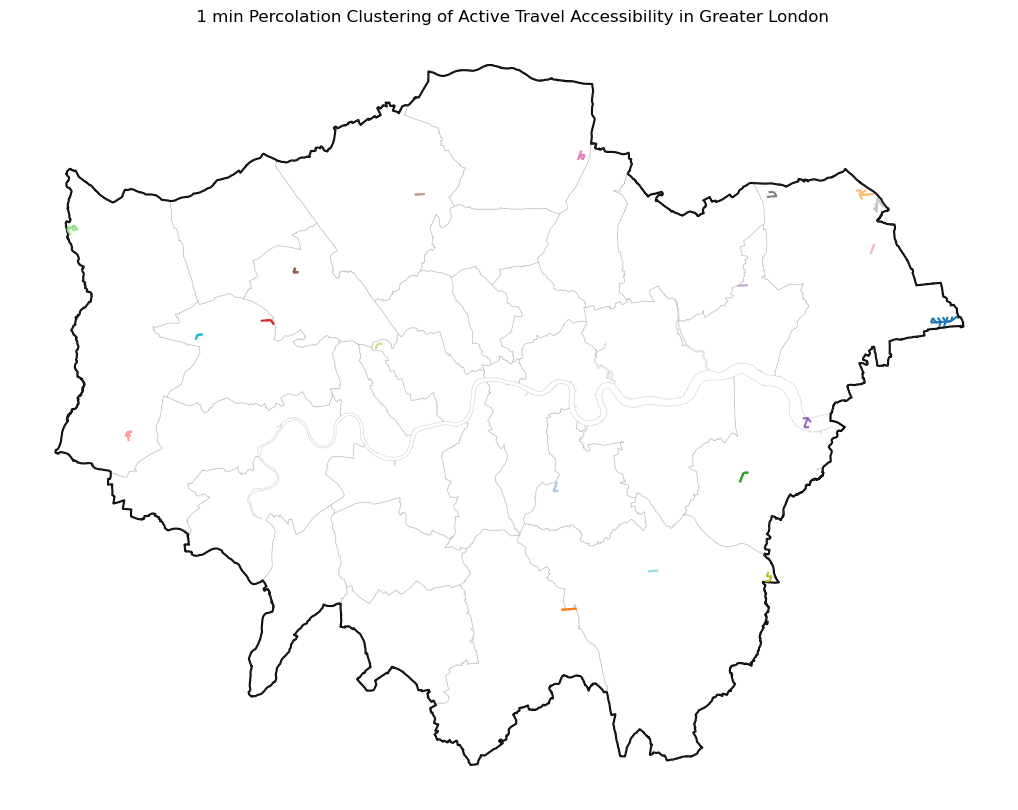

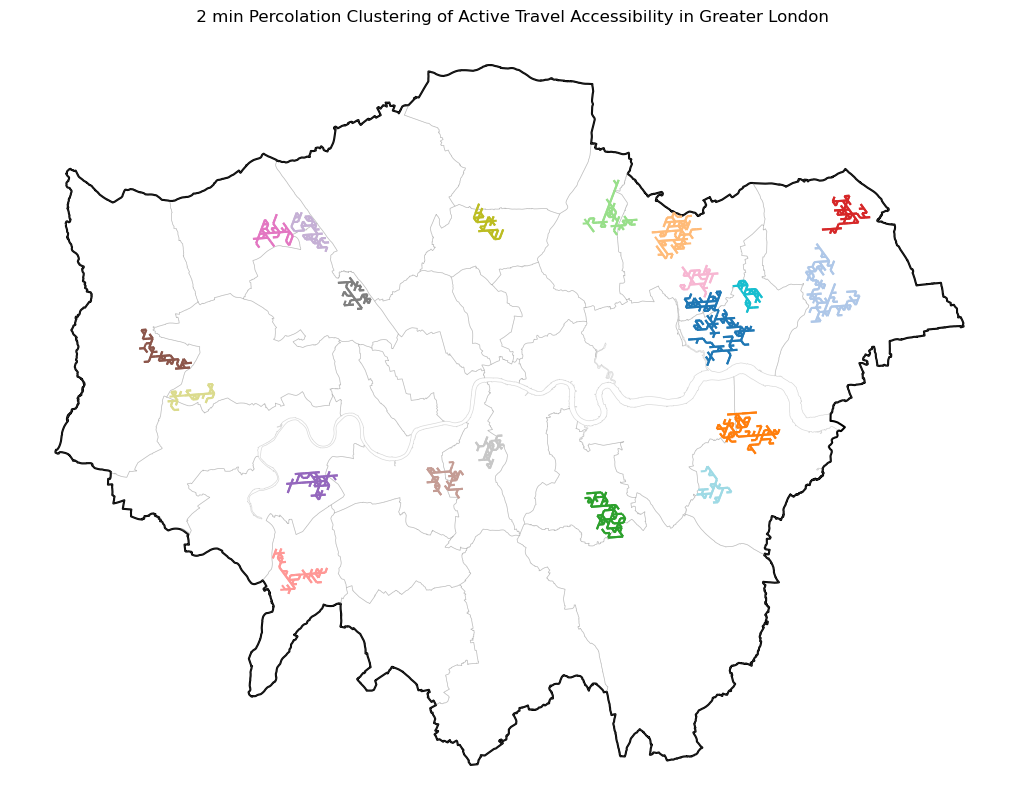

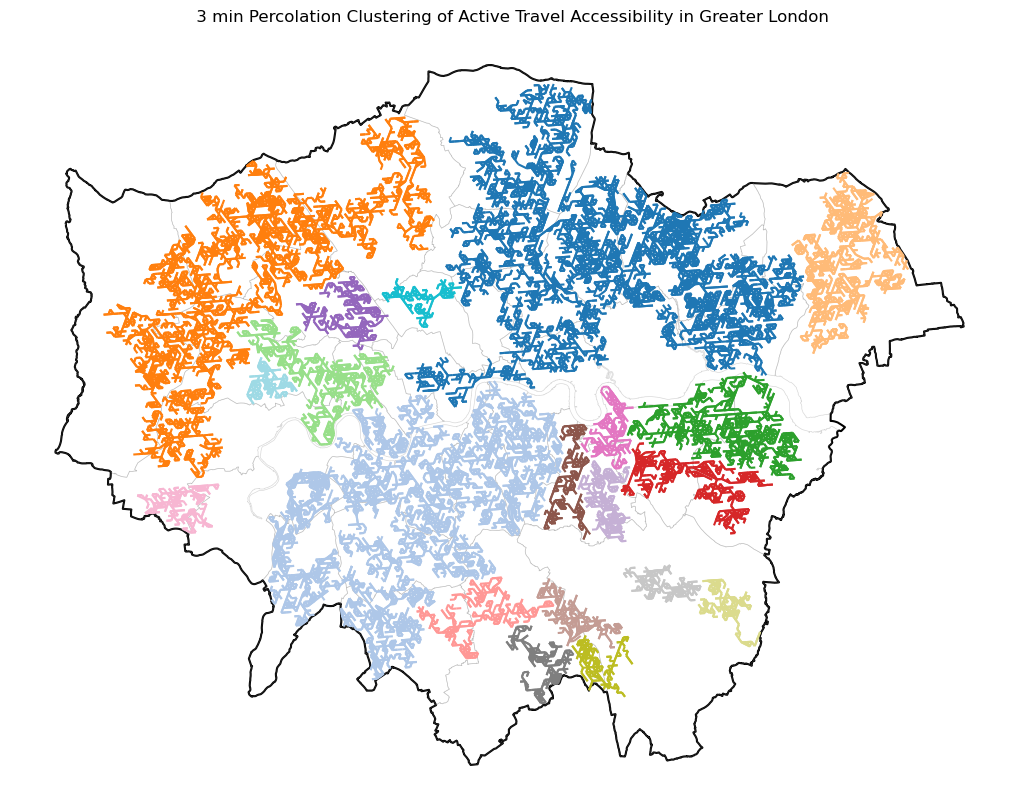

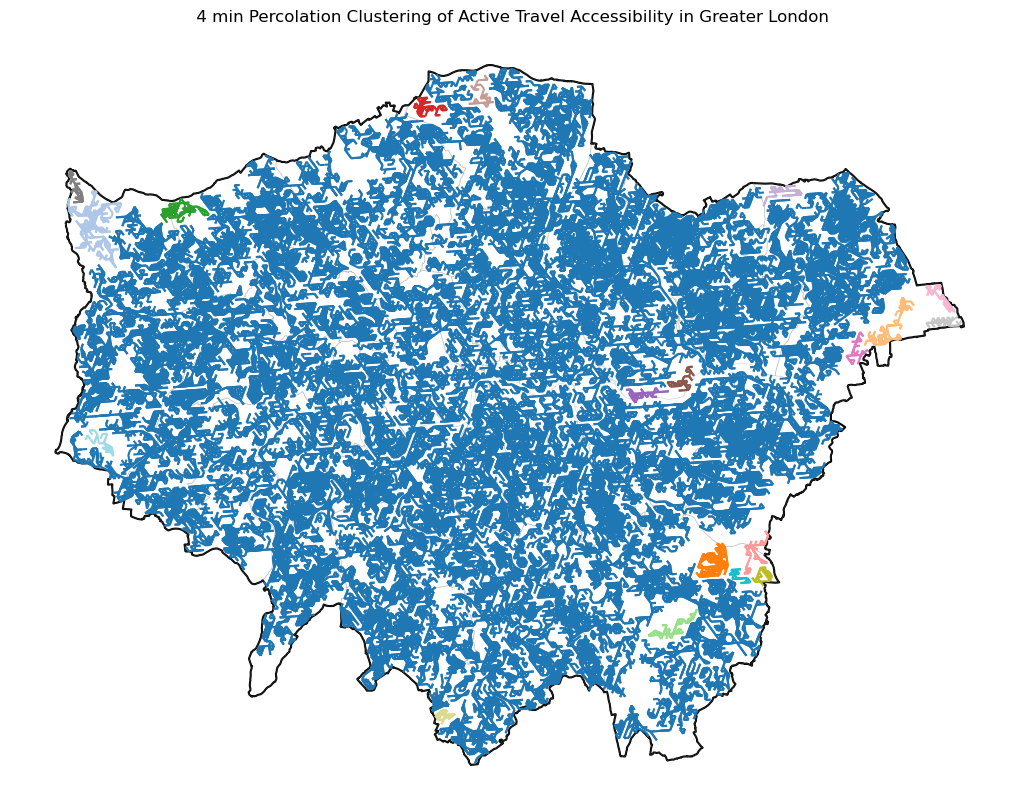

In [17]:
for time_threshold in [1,2,3,4]:
    clustered_gdf = percolation_clustering(valid_od_matrix, time_threshold)

    # Identify the largest 10 clusters
    top_clusters = clustered_gdf['cluster_id'].value_counts().nlargest(20).sort_values(ascending=False).index
    # print(clustered_gdf['cluster_id'].value_counts().nlargest(10))
    # print(top_clusters)
    
    # Filter the connections to include only the largest 10 clusters
    top_clustered_gdf = clustered_gdf[clustered_gdf['cluster_id'].isin(top_clusters)]
    top_clustered_gdf = gpd.GeoDataFrame(top_clustered_gdf, geometry='geometry', crs=origins_destinations.crs)

    # Get unique cluster IDs and sort them by frequency (largest first)
    unique_clusters = top_clustered_gdf['cluster_id'].value_counts().index.tolist()
    
    # Create a mapping from old cluster IDs to new cluster IDs (1-10)
    cluster_id_mapping = {old_id: new_id for new_id, old_id in enumerate(unique_clusters, start=1)}
    
    # Map the old cluster IDs to new cluster IDs in the GeoDataFrame
    top_clustered_gdf['cluster_id'] = top_clustered_gdf['cluster_id'].map(cluster_id_mapping)
    
    # Visualize the clusters
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))

    # Plot the boundary in the background
    gla_boundary.boundary.plot(ax=ax, edgecolor='black')
    borough_boundary.boundary.plot(ax=ax, edgecolor='gray', linewidth=0.5,alpha=0.3)

    # Plot the clustered connections
    top_clustered_gdf.plot(ax=ax, column='cluster_id', linewidth=1.5, legend=False, cmap='tab20')

    plt.title(f' {time_threshold} min Percolation Clustering of Active Travel Accessibility in Greater London')
    plt.axis('off')
    plt.show()

##### ADD the connected hexagon mapping
##### the disconnected in 8 min, because of parks?

In [17]:
# Initialize lists to track changes in the largest connected component
lengths = []
components = []

thresholds = np.linspace(0, 45, num=46)

# Percolation by increasing thresholds of travel time
for threshold in thresholds:
    G_ = G.copy()
    edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['travel_time'] > threshold]
    G_.remove_edges_from(edges_to_remove)

    # Analyzing connected components
    largest_cc = len(max(nx.connected_components(G_), key=len))
    lengths.append(largest_cc)
    component_labels = {node: index for index, component in enumerate(nx.connected_components(G_)) for node in component}
    components.append(pd.DataFrame.from_dict(component_labels, orient='index', columns=['component']))

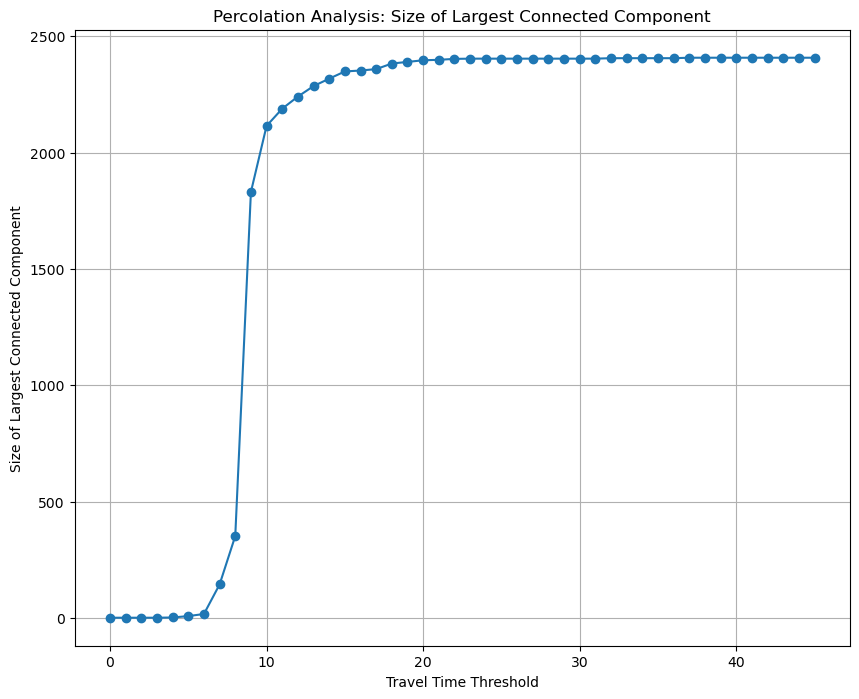

In [18]:
# Plotting the size of the largest connected component
plt.figure(figsize=(10, 8))
plt.plot(np.linspace(0, 45, num=46), lengths, marker='o')
plt.title('Percolation Analysis: Size of Largest Connected Component')
plt.xlabel('Travel Time Threshold')
plt.ylabel('Size of Largest Connected Component')
plt.grid(True)
plt.show()